### Package and angular distance

In [1]:
#Computing
from astropy.io import fits
import numpy as np
import math
import treecorr
import time
import random
import pyccl as ccl
import gc

#for masks:
#import healpy as hp
#import h5py as h5
#import healsparse as hs


#for saving:
import pickle

#for ploting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Math



cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



# Data for the test
Here it is eBOSS SGC ELG sample

In [3]:
"""
# eBOSS ELG
"""
path='/global/cfs/cdirs/des/william/BOSS_eBOSS/'

# %%
hdul=fits.open(path+'eBOSS_ELG_clustering_data-SGC-vDR16.fits')
data=hdul[1].data
#print(data.columns)
ra_eboss_ELG_south=data['ra']
dec_eboss_ELG_south=data['dec']
z_eboss_ELG_south=data['z']
weight_eboss_ELG_south_sys=data['WEIGHT_SYSTOT']
weight_eboss_ELG_south_cp=data['WEIGHT_CP']
weight_eboss_ELG_south_noz=data['WEIGHT_NOZ']
weight_eboss_ELG_south=weight_eboss_ELG_south_sys*weight_eboss_ELG_south_cp*weight_eboss_ELG_south_noz

# %%
hdul=fits.open(path+'/eBOSS_ELG_clustering_random-SGC-vDR16.fits')
data=hdul[1].data
#print(data.columns)
ra_rand_eboss_ELG_south=data['ra']
dec_rand_eboss_ELG_south=data['dec']
z_rand_eboss_ELG_south=data['z']
weight_rand_eboss_ELG_south_sys=data['WEIGHT_SYSTOT']
weight_rand_eboss_ELG_south_cp=data['WEIGHT_CP']
weight_rand_eboss_ELG_south_noz=data['WEIGHT_NOZ']
weight_rand_eboss_ELG_south=weight_rand_eboss_ELG_south_sys*weight_rand_eboss_ELG_south_cp*weight_rand_eboss_ELG_south_noz




# The integrated 2-pt auto-corrfunction 

We evalute $w_{xx}(z_i)=\int_{\theta_{\rm min}}^{\theta_{\rm max}} {\rm d}\theta \, \frac{\theta^{\alpha}}{\int d\theta\, \theta^{\alpha}}\, \frac{DD-DR-RD+RR}{RR}(\theta)$, where the sample $x$ is distributed into $N_z$ bins: $z_i\pm \Delta z/2$

In [4]:
def w_xx(sample_x, scale_range, z_range, Ntheta, Nz, Npatch, z_for_rand ,Eta_rand):
    '''
    Code to compute the auto-correlation of sample_x,
    -------------------------------------
    Outputs:
    Wz: is a Nz x Nalpha array, where Nz is the number of z bins, and Nalpha the number of scale weighting
    Thus Wz[iz][ialpha] is the value for wxx for the z-bin iz, and the scale weighting ialpha
    
    Err is a Nz x Nalpha uncertainty array associated to WZ.

    Multi_cov is the Nz x Njkk x Nalpha array usefull to compute the full covariance!!

    For std tests, use directly WZ and Err. Usually redshift covariance is negligible.
    -------------------------------------
    Inputs:
    sample_x: name of the sample, the only option now is sample_x='photo' and 'eBOSS ELG'
    
    scale_range is an array = [convention,scale_min,scale_max], with convention ='rp' or 'theta', with scale_min/max IN ARCMIN or MPC
    z_for_rand is an array = [zmin,zmax]

    Ntheta is the number of theta-bins (default use 10)
    Nz is the number of z-bins
    Npatch the number of Jkk patches to evaluate the cov
    
    z_for_rand==True means there are redshifts for randoms
    Eta_rand is how many more randoms you want, to evaluate the DD/RR counts
    -------------------------------------
    '''
    print('evaluate the auto-corr of ', sample_x)
    print('for',z_range[0], '<z<',z_range[1],'  with ', Nz, ' bins')

    zmin=z_range[0]
    zmax=z_range[1]
    dz=(zmax-zmin)/Nz
    
    # You can add other options, with another elif
    if sample_x=='eBOSS ELG':
        ra_gal =ra_eboss_ELG_south
        dec_gal =dec_eboss_ELG_south
        z_gal =z_eboss_ELG_south
        w_gal =  weight_eboss_ELG_south#np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand =ra_rand_eboss_ELG_south
        dec_rand =dec_rand_eboss_ELG_south
        w_rand =  weight_rand_eboss_ELG_south
        if z_for_rand==True:
            z_rand=z_rand_eboss_ELG_south
    elif sample_x=='add your option':
        ra_gal =1
        dec_gal =1
        z_gal =1
        w_gal = np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand =1
        dec_rand =1
        w_rand =  np.array([1 for i in ra_rand])
        if z_for_rand==True:
            z_rand=1
    else:
        print('sample_x not included in the code')

    print(len(ra_gal) ,' galaxies ')
    print(len(ra_rand) ,'randoms ')

    
    Wz=[]
    Cov=[]
    Err=[]
    Multi_cov=[]
    
    #create a catalog to have the Jkk patches
    cat_patch = treecorr.Catalog(ra=ra_gal,dec=dec_gal,w=w_gal,ra_units='degrees',dec_units='degrees',npatch=Npatch)

    for iz in range(Nz):
        zmean_i=zmin+(iz+0.5)*dz
        zmin_i=zmin+(iz)*dz
        zmax_i=zmin+(iz+1)*dz

        if scale_range[0]=='theta':
            theta_min=scale_range[1]/60 # arcmin to degree
            theta_max=scale_range[2]/60 # arcmin to degree
        elif scale_range[0]=='rp':
            theta_min=scale_range[1]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
            theta_max=scale_range[2]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
        else:
            print('error scale conv')
            return 0,0,0

            
        print('zi=',round(zmean_i,3),' dz=',round(dz,3))
        
        sel_gal_subbin=((z_gal>=zmin_i)&(z_gal<zmax_i))
        cat_gal_subbin=treecorr.Catalog(ra=ra_gal[sel_gal_subbin],dec=dec_gal[sel_gal_subbin],w=w_gal[sel_gal_subbin],ra_units='degrees',dec_units='degrees',patch_centers=cat_patch.patch_centers)
        

        # Do we have z for randoms: 
        if z_for_rand==True:
            sel_rand_subbin=((z_rand>=zmin_i)&(z_rand<zmax_i))
        else:
            sel_rand_subbin=np.array([True for r in ra_rand])
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand[sel_rand_subbin])
        Nrand=Eta_rand*len(ra_gal[sel_gal_subbin])
        Index=random.choices(range(Ntot), k=Nrand)
        
        
        ra_rand_select=ra_rand[sel_rand_subbin][Index]
        dec_rand_select=dec_rand[sel_rand_subbin][Index]
        w_rand_select=w_rand[sel_rand_subbin][Index]
    
        cat_rand_subbin=treecorr.Catalog(ra=ra_rand_select,dec=dec_rand_select,w=w_rand_select,ra_units='degrees',dec_units='degrees', patch_centers=cat_patch.patch_centers)
    
        wxx  = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        rrxx = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        drxx = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)

        #Now I use r as a name instead of theta
        rlist=wxx.rnom
        redges=wxx.right_edges-wxx.left_edges
        #print(rlist)
        #print(redges)
        def integ_wxx(w1):
            '''
            integrate w1 over theta, with different scales weighting, defined by List_alpha:
            W(theta)=theta**alpha/norm
            '''
            List_alpha=[-1,0,1]
            Results_alpha=[]
            Noweight=w1
            for alpha in  List_alpha:
                w1b=0
                norm=0
                for ir in range(len(w1)):
                    w1b+=w1[ir]*rlist[ir]**alpha*redges[ir]
                    norm+=rlist[ir]**alpha*redges[ir]
                Results_alpha.append(w1b/norm)

            return np.array(Results_alpha)
            
            
        rrxx.process(cat_rand_subbin,cat_rand_subbin)
        drxx.process(cat_rand_subbin,cat_gal_subbin)
        
        wxx.process(cat_gal_subbin,cat_gal_subbin)
        wxx.calculateXi(rr=rrxx,dr=drxx)
         
        my_funct = lambda corrs: integ_wxx(corrs[0].xi)
        corrs = [wxx]
            
        ratio = my_funct(corrs)  
        cov = treecorr.estimate_multi_cov(corrs, 'jackknife', func=my_funct)
        multi_cov=treecorr.build_multi_cov_design_matrix(corrs,'jackknife', func=my_funct, comm=None)
        
        Wz.append(ratio)
        Cov.append(cov)
        Err.append([np.sqrt(cov[i][i]) for i in range(np.size(cov,0))])
        Multi_cov.append(multi_cov[0])
        
        del(cat_gal_subbin)
        del(cat_rand_subbin)
        gc.collect()
    return(Wz,Err,Multi_cov)

    

# Plots

In [8]:
A0,B0,C0=w_xx(sample_x='eBOSS ELG', scale_range=['theta',1,10], z_range=[0.6,1], Ntheta=10, Nz=8, Npatch=100, z_for_rand=True ,Eta_rand=5)

evaluate the auto-corr of  eBOSS ELG
for 0.6 <z< 1   with  8  bins
89967  galaxies 
3609460 randoms 
zi= 0.625  dz= 0.05
zi= 0.675  dz= 0.05
zi= 0.725  dz= 0.05
zi= 0.775  dz= 0.05
zi= 0.825  dz= 0.05
zi= 0.875  dz= 0.05
zi= 0.925  dz= 0.05
zi= 0.975  dz= 0.05


In [51]:
A1,B1,C1=w_xx(sample_x='eBOSS ELG', scale_range=['rp',1.5,5], z_range=[0.6,1], Ntheta=10, Nz=8, Npatch=100, z_for_rand=True ,Eta_rand=5)

evaluate the auto-corr of  eBOSS ELG
for 0.6 <z< 1   with  8  bins
89967  galaxies 
3609460 randoms 
zi= 0.625  dz= 0.05
zi= 0.675  dz= 0.05
zi= 0.725  dz= 0.05
zi= 0.775  dz= 0.05
zi= 0.825  dz= 0.05
zi= 0.875  dz= 0.05
zi= 0.925  dz= 0.05
zi= 0.975  dz= 0.05


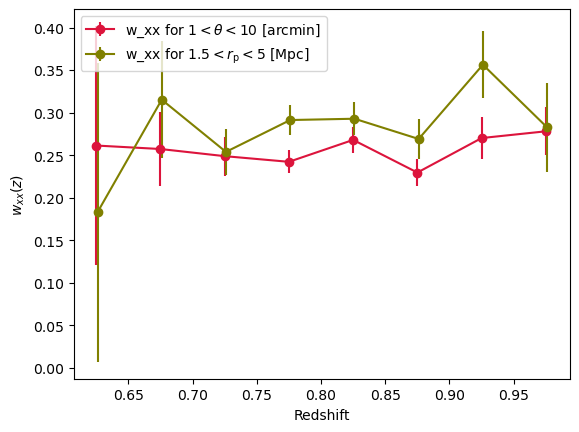

In [75]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{xx}(z)$')

Z8=np.array([0.625+0.05*i for i in range(8)]) #Z list for 8 bins

plt.errorbar(Z8, [A0[i][ialpha] for i in range(8)],yerr=[B0[i][ialpha] for i in range(8)],color='crimson',marker='o',label=r'w_xx for $1<\theta<10$ [arcmin]')
plt.errorbar(Z8+0.001, [A1[i][ialpha] for i in range(8)],yerr=[B1[i][ialpha] for i in range(8)],color='olive',marker='o',label=r'w_xx for $1.5<r_{\rm p}<5$ [Mpc]')

plt.legend()

In [74]:
#for ialpha=1, and the scale range above: 
wdm_theta=np.array([0.00943, 0.00873, 0.00814, 0.00763, 0.00719, 0.00681, 0.00647, 0.00617])
wdm_rp=np.array([0.00893, 0.00871, 0.00852, 0.00833, 0.00814, 0.00797, 0.00781, 0.00767])

print(' for different alpha and scales, use the w_dm_cz code in the github repo')

 for different alpha and scales, use the w_dm_cz code in the github repo


What are the corresponding  b^2, are they consistent, and compatible with usual ELG bias model ?


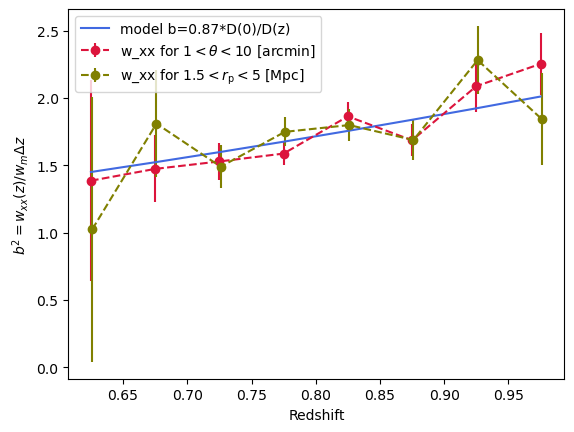

In [76]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$b^2=w_{xx}(z)/w_m\Delta z$')

Z8=np.array([0.625+0.05*i for i in range(8)]) #Z list for 8 bins

plt.errorbar(Z8, [A0[i][ialpha]/wdm_theta[i]*0.05 for i in range(8)],yerr=[B0[i][ialpha]/wdm_theta[i]*0.05  for i in range(8)],color='crimson',linestyle='--',marker='o',label=r'w_xx for $1<\theta<10$ [arcmin]')
plt.errorbar(Z8+0.001, [A1[i][ialpha]/wdm_rp[i]*0.05  for i in range(8)],yerr=[B1[i][ialpha]/wdm_rp[i]*0.05  for i in range(8)],color='olive',linestyle='--',marker='o',label=r'w_xx for $1.5<r_{\rm p}<5$ [Mpc]')


b2_model=[(0.87*D_cosmo(0)/D_cosmo(z))**2 for z in Z8]

plt.plot(Z8,b2_model,label='model b=0.87*D(0)/D(z)',color='royalblue')
plt.legend()
print('What are the corresponding  b^2, are they consistent, and compatible with usual ELG bias model ?')

In [8]:
# this is for the cross-corr code:
A2,B2,C2=w_xx(sample_x='eBOSS ELG', scale_range=['rp',1.5,5], z_range=[0.6,0.85], Ntheta=10, Nz=5, Npatch=100, z_for_rand=True ,Eta_rand=5)
ialpha=1
print([round(A2[i][ialpha],3) for i in range(5)])

[0.359, 0.353, 0.247, 0.285, 0.296]


## This is how to compute the redshift-covariance matrix from multi_cov returned by the code !

In [67]:
Nz=8
Nalpha=3
Njkk=100

C_mat=C1
w_wz1=[] # this is the auto-correlation
Cov_wz1=[] # its covariance
Err_wz1=[] # the errorbars

for ialpha in range(Nalpha):
    D0=np.array([[C_mat[iz][jk][ialpha] for jk in range(Njkk)]for iz in range(Nz)],dtype=np.float64)

    w_wz1.append(np.array([1/Njkk*np.sum(D0[jz]) for jz in range(Nz)],np.float64))
    Cov_wz1.append(np.array([[ ( Njkk-1)/Njkk* np.sum((D0[imat] - w_wz1[ialpha][imat]) * (D0[jmat] - w_wz1[ialpha][jmat])) for jmat in range(Nz)] for imat in range(Nz)],np.float64))    
    Err_wz1.append([np.sqrt(Cov_wz1[ialpha][i][i]) for i in range(Nz)])

In [68]:
#first dim in Nalpha, then Nz
print(np.shape(w_wz1))
print(np.shape(Cov_wz1))

(3, 8)
(3, 8, 8)


Is the direct Treecorr estimate compatible with the one from the Multicov ?


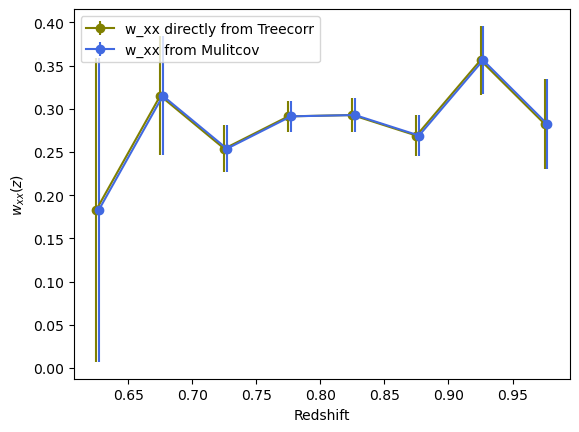

In [73]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{xx}(z)$')

plt.errorbar(Z8, [A1[i][ialpha] for i in range(8)],yerr=[B1[i][ialpha] for i in range(8)],color='olive',marker='o',label=r'w_xx directly from Treecorr')
plt.errorbar(Z8+0.002, w_wz1[ialpha] ,yerr=Err_wz1[ialpha],marker='o',color='royalblue',label=r'w_xx from Mulitcov')

plt.legend()
print('Is the direct Treecorr estimate compatible with the one from the Multicov ?')